## Imports

In [ ]:
import matplotlib.pyplot as plt
import gymnasium as gym
import random
import math
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from IPython.display import clear_output

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

## Prepare env

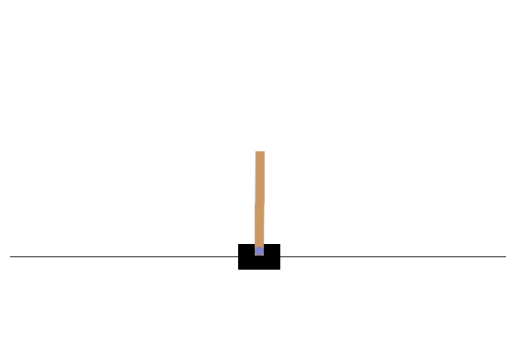

In [3]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset()
plt.imshow(env.render());
plt.axis("off");

In [202]:
env.reset()
done, terminated = False, False
step_i = 0

0.0 34 True False {}


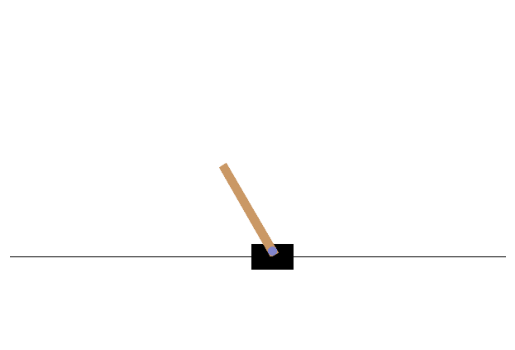

In [236]:
step_i += 1

action = env.action_space.sample()
state, reward, done, terminated, info = env.step(action)
print(reward, step_i, done, terminated, info)
plt.imshow(env.render());
plt.axis("off");

## Replay buffer

In [ ]:
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque([], maxlen=capacity)

    def store(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## Network

In [ ]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

## Agent

In [ ]:
class Agent(object):
    def __init__(
        self,
        env,
        batch_size: int = 5,
        buffer_size: int = 1000,
        eps_start: float = 0.9,
        eps_end: float = 0.05,
        eps_decay: int = 1000,
        gamma: float = 0.99,
        tau: float = 0.005,
        lr: float = 1e-4,
    ):
        assert batch_size <= buffer_size, "batch_size must be equal or lower than buffer_size"
        
        self.env = env
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.lr = lr
        self.loss = nn.MSELoss()
        
        n_actions = self.env.action_space.n
        n_observations = len(self.env.reset()[0])
        
        self.policy_net = DQN(n_observations, n_actions).to(device)
        self.target_net = DQN(n_observations, n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.memory = ReplayMemory(buffer_size)

        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=self.lr, amsgrad=True)

        self.steps_done = 0
        self.episode_durations = []
        

    def select_action(self, state):
        eps_threshold = (
            self.eps_end +
            (self.eps_start - self.eps_end) *
            math.exp(-1. * (self.steps_done / self.eps_decay))
        )

        self.steps_done += 1
        
        if random.random() > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1).indices.view(1, 1)
        else:
            random_action = self.env.action_space.sample()
            return torch.tensor([[random_action]], device=device, dtype=torch.long)
        
    def play_episode(self, train=True):
        state, _ = self.env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)


        for t in count():
            action = self.select_action(state)
            observation, reward, terminated, truncated, _ = self.env.step(action.item())

            reward = torch.tensor([reward], device=device)
            done = truncated or terminated

            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(
                    observation,
                    dtype=torch.float32,
                    device=device
                ).unsqueeze(0)
            
            self.memory.store(state, action, next_state, reward)
            
            state = next_state

            if train:
                self.optimize_model()

                # Soft update of target network
                target_net_state_dict = self.target_net.state_dict()
                policy_net_state_dict = self.policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] += (
                        policy_net_state_dict[key] * self.tau -
                        target_net_state_dict[key] * self.tau
                    )
                self.target_net.load_state_dict(target_net_state_dict)
            else:
                self.render(t, done)  
            
            
            if done:
                if train:
                    self.episode_durations.append(t + 1)
                    self.plot_durations()
                break

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return
        
        # Sample random minibatch of transitions (s_i, a_i, r_i, s_i+1) from replay memory
        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(
            tuple(map(lambda s: s is not None, batch.next_state)),
            device=device,
            dtype=torch.bool
        )
        non_final_next_states = torch.cat(
            [s for s in batch.next_state if s is not None]
        )

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Q-values of chosen actions in state
        q_pred = self.policy_net(state_batch).gather(1, action_batch)

        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(self.batch_size, device=device)
        with torch.no_grad():
            # V-func values for next non-final states
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1).values
        # Compute the expected Q-values
        q_target = (next_state_values * self.gamma) + reward_batch

        batch_loss = self.loss(q_pred, q_target.unsqueeze(1))

        self.optimizer.zero_grad()
        batch_loss.backward()

        self.optimizer.step()

    def render(self, t, done):
        clear_output(wait=True)
        
        plt.imshow(self.env.render())
        plt.pause(0.001)
        plt.xlabel(f"Timestep: {t}")
        plt.ylabel(f"{done}")

        

    def plot_durations(self, show_result=False):
        plt.figure(1)
        durations_t = torch.tensor(self.episode_durations, dtype=torch.float)
        if show_result:
            plt.title('Result')
        else:
            plt.clf()
            plt.title('Training...')
        plt.xlabel('Episode')
        plt.ylabel('Duration')
        plt.plot(durations_t.numpy())

        if len(durations_t) >= 100:
            means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(99), means))
            plt.plot(means.numpy())

        plt.pause(0.001)

        clear_output(wait=True)

    def train(self, num_episodes):
        for _ in range(num_episodes):
            self.play_episode(train=True)

    def test(self):
        self.play_episode(train=False)

In [611]:
agent = Agent(env, batch_size=200)

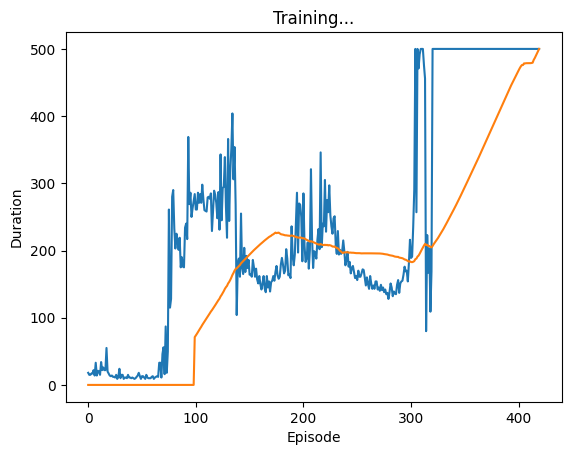

In [620]:
agent.train(100)

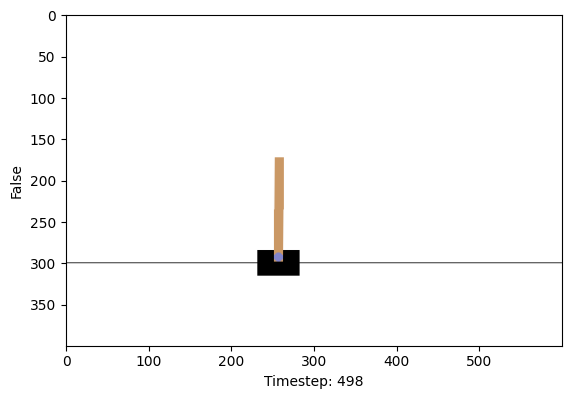

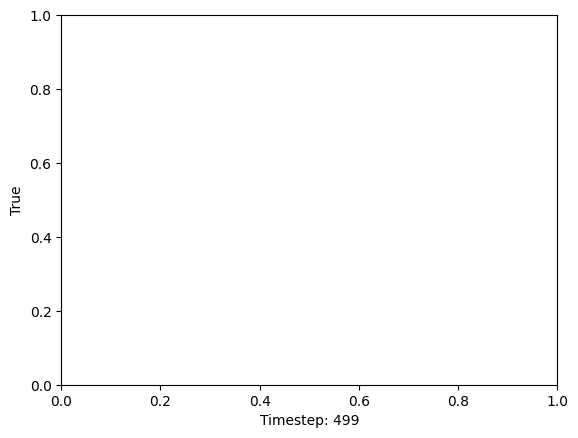

In [621]:
agent.test()